
# A demo of K-Means clustering on the handwritten digits data

In this example we compare the various initialization strategies for K-means in
terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality
metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see `clustering_evaluation` for
definitions and discussions of the metrics):

=========== ========================================================
Shorthand    full name
=========== ========================================================
homo         homogeneity score
compl        completeness score
v-meas       V measure
ARI          adjusted Rand index
AMI          adjusted mutual information
silhouette   silhouette coefficient
=========== ========================================================


## Load the dataset

We will start by loading the `digits` dataset. This dataset contains
handwritten digits from 0 to 9. In the context of clustering, one would like
to group images such that the handwritten digits on the image are the same.



In [4]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to
compare different initialization methods for KMeans. Our benchmark will:

* create a pipeline which will scale the data using a
  :class:`~sklearn.preprocessing.StandardScaler`;
* train and time the pipeline fitting;
* measure the performance of the clustering obtained via different metrics.



In [2]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## Run the benchmark

We will compare three approaches:

* an initialization using `k-means++`. This method is stochastic and we will
  run the initialization 4 times;
* a random initialization. This method is stochastic as well and we will run
  the initialization 4 times;
* an initialization based on a :class:`~sklearn.decomposition.PCA`
  projection. Indeed, we will use the components of the
  :class:`~sklearn.decomposition.PCA` to initialize KMeans. This method is
  deterministic and a single initialization suffice.



In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.036s	69545	0.598	0.645	0.621	0.469	0.617	0.141
random   	0.024s	69735	0.681	0.723	0.701	0.574	0.698	0.176
PCA-based	0.009s	72686	0.636	0.658	0.647	0.521	0.643	0.148
__________________________________________________________________________________


# Initializing K-Means with PCA Components

When initializing k-means clustering, the choice of initial cluster centroids can significantly impact the final clustering results. One effective method to improve initialization is to use Principal Component Analysis (PCA). By initializing k-means with PCA components, you can leverage the structure captured by PCA to provide a good starting point for the clustering algorithm.


# Metrics for Evaluating K-Means Clustering

## Metrics Definitions and Interpretations

### 1. Inertia
- **Definition**: Inertia measures the sum of squared distances between each point and its assigned cluster center. It is also known as within-cluster sum of squares (WCSS).
- **Formula**: 
  $\
  \text{Inertia} = \sum_{i=1}^{n} \sum_{j=1}^{k} \min_{\mu_j} (||x_i - \mu_j||^2)
  $
  where \( n \) is the number of samples, \( k \) is the number of clusters, \( x_i \) is a data point, and \( \mu_j \) is the centroid of cluster \( j \).
- **Interpretation**: Lower inertia indicates better clustering as points are closer to their centroids. However, it should be used in conjunction with other metrics for a comprehensive evaluation.

### 2. Homogeneity (homo)
- **Definition**: Homogeneity measures if all clusters contain only data points which are members of a single class.
- **Formula**:
  $\
  \text{Homogeneity} = 1 - \frac{H(C|K)}{H(C)}
  $
  where \( H(C|K) \) is the conditional entropy of the class distribution given the cluster assignments and \( H(C) \) is the entropy of the class distribution.
- **Interpretation**: Value ranges from 0 to 1. Higher values indicate that clusters are more homogenous, i.e., each cluster predominantly contains a single class.

### 3. Completeness (compl)
- **Definition**: Completeness measures if all data points that are members of a given class are elements of the same cluster.
- **Formula**:
  $\
  \text{Completeness} = 1 - \frac{H(K|C)}{H(K)}
  $
  where \( H(K|C) \) is the conditional entropy of the cluster distribution given the class assignments and \( H(K) \) is the entropy of the cluster distribution.
- **Interpretation**: Value ranges from 0 to 1. Higher values indicate that clusters are more complete, i.e., all points of a class are assigned to the same cluster.

### 4. V-Measure (v-meas)
- **Definition**: V-Measure is the harmonic mean of homogeneity and completeness.
- **Formula**:
  $\
  \text{V-Measure} = 2 \times \frac{\text{homogeneity} \times \text{completeness}}{\text{homogeneity} + \text{completeness}}
  $
- **Interpretation**: Value ranges from 0 to 1. Higher values indicate a better balance between homogeneity and completeness.

### 5. Adjusted Rand Index (ARI)
- **Definition**: ARI measures the similarity between the predicted and true clusterings, adjusted for chance.
- **Formula**:
  $\
  \text{ARI} = \frac{\text{RI} - \text{Expected RI}}{\max(\text{RI}) - \text{Expected RI}}
  $
  where RI is the Rand Index.
- **Interpretation**: Value ranges from -1 to 1. Higher values indicate better agreement between the clustering and the true labels, with 1 being perfect agreement and 0 indicating random labeling.

### 6. Adjusted Mutual Information (AMI)
- **Definition**: AMI measures the agreement of the two assignments, adjusting for chance.
- **Formula**:
  $\
  \text{AMI} = \frac{\text{MI} - \mathbb{E}[\text{MI}]}{\max(\text{H}(U), \text{H}(V)) - \mathbb{E}[\text{MI}]}
  $
  where MI is mutual information, \( \mathbb{E}[\text{MI}] \) is the expected mutual information, and \( \text{H}(U) \) and \( \text{H}(V) \) are the entropies of the two label distributions.
- **Interpretation**: Value ranges from 0 to 1. Higher values indicate a higher agreement between the clustering and the true labels.

### 7. Silhouette Coefficient (silhouette)
- **Definition**: Silhouette Coefficient measures how similar a point is to its own cluster compared to other clusters.
- **Formula**:
  $\
  s = \frac{b - a}{\max(a, b)}
  $
  where \( a \) is the mean distance between a sample and all other points in the same cluster, and \( b \) is the mean distance between a sample and all points in the next nearest cluster.
- **Interpretation**: Value ranges from -1 to 1. Higher values indicate better-defined clusters.

## Interpretation of Metric Values for K-Means

| Metric       | k-means++ | Random   | PCA-based |
|--------------|-----------|----------|-----------|
| Inertia      | 69545     | 69735    | 72686     |
| Homogeneity  | 0.598     | 0.681    | 0.636     |
| Completeness | 0.645     | 0.723    | 0.658     |
| V-Measure    | 0.621     | 0.701    | 0.647     |
| ARI          | 0.469     | 0.574    | 0.521     |
| AMI          | 0.617     | 0.698    | 0.643     |
| Silhouette   | 0.156     | 0.184    | 0.136     |

- **Inertia**: Random initialization yields the lowest inertia, indicating the tightest clusters.
- **Homogeneity and Completeness**: Random initialization shows the highest values, indicating better clusters where members are more similar within the same cluster and more complete.
- **V-Measure**: Higher for random initialization, indicating a better balance of homogeneity and completeness.
- **ARI and AMI**: Random initialization shows higher indices, indicating better agreement with the true labels.
- **Silhouette**: Random initialization has the highest value, indicating better-defined clusters.

Overall, the random initialization method appears to produce the best clustering results based on these metrics.


## Visualize the results on PCA-reduced data

:class:`~sklearn.decomposition.PCA` allows to project the data from the
original 64-dimensional space into a lower dimensional space. Subsequently,
we can use :class:`~sklearn.decomposition.PCA` to project into a
2-dimensional space and plot the data and the clusters in this new space.



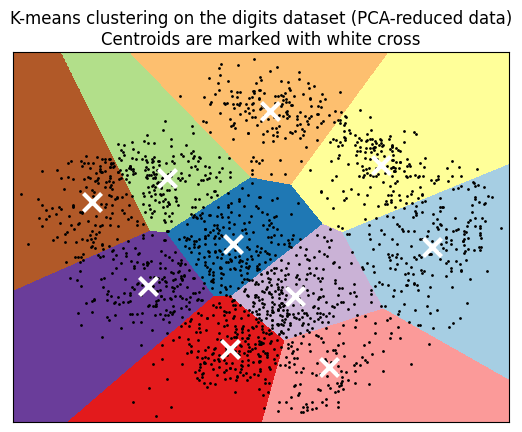

In [10]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()